To use a batched A2C we have to adapt both the step method and how we store information for the update.
In particular:
1. Instead of using observations of the environment with everything attached, elaborate the information and extract only the useful variables, so that they can be stacked in numpy arrays when possbile.
2. step method works with observation, but should work with a batch of states and available actions; Probably it will be infeasible to vectorize the selection of the parameters of the actions, because the output and the procedure varies from action to action.
3. The part in which we compute the loss is okay, because we use only the critic to make predictions, so the only problem is to store the information in batches.

NOTE: remember to add all networks to the optimizer initialization

In [1]:
from Utils.train_batched_A2C import *
from AC_modules.BatchedA2C import MoveToBeaconSpatialA2C
import torch

pygame 1.9.6
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
def train_batched_A2C(agent, game_params, lr, n_train_processes, max_train_steps, 
                      unroll_length, max_episode_steps, test_interval=100):
    
    test_env = init_game(game_params, max_episode_steps)
    envs = ParallelEnv(n_train_processes, game_params, max_episode_steps)

    optimizer = torch.optim.Adam(agent.AC.parameters(), lr=lr)

    score = []
    critic_losses = [] 
    actor_losses = []
    entropies = []
    
    step_idx = 0
    while step_idx < max_train_steps:
        s_lst, a_lst, r_lst, done_lst, bootstrap_lst, s_trg_lst = list(), list(), list(), list(), list(), list()
        log_probs = []
        distributions = []
        s, a_mask = envs.reset()
        for _ in range(unroll_length):

            a, log_prob, probs = agent.step(s, a_mask)
            a_lst.append(a)
            log_probs.append(log_prob)
            distributions.append(probs)

            s_prime, r, done, bootstrap, s_trg, a_mask = envs.step(a)
            s_lst.append(s)
            r_lst.append(r)
            done_lst.append(done)
            bootstrap_lst.append(bootstrap)
            s_trg_lst.append(s_trg)

            s = s_prime
            step_idx += 1 #n_train_processes

        s_lst = np.array(s_lst).transpose(1,0,2,3,4)
        r_lst = np.array(r_lst).transpose(1,0)
        done_lst = np.array(done_lst).transpose(1,0)
        bootstrap_lst = np.array(bootstrap_lst).transpose(1,0)
        s_trg_lst = np.array(s_trg_lst).transpose(1,0,2,3,4)
        
        ### Update time ###
        #print("len(r_lst): ", r_lst.shape)
        #print("len(s_lst): ", s_lst.shape)
        #print("len(done_lst): ", done_lst.shape)
        #print("len(s_trg_lst): ", s_trg_lst.shape)
        critic_loss, actor_loss, entropy = agent.compute_ac_loss(r_lst, log_probs, distributions, 
                                                                 s_lst, done_lst, bootstrap_lst, s_trg_lst)

        
        loss = (critic_loss + actor_loss).mean()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        #print("backward done")
        
        #print("critic_loss: ", critic_loss)
        #print("actor_loss: ", actor_loss)
        #print("entropy: ", entropy)
        critic_losses.append(critic_loss.item())
        actor_losses.append(actor_loss.item())
        entropies.append(entropy.item())
        
        ### Test time ###
        if step_idx % test_interval == 0:
            avg_score = test(step_idx, agent, test_env)
            score.append(avg_score)
    envs.close()
    
    losses = dict(critic_losses=critic_losses, actor_losses=actor_losses, entropies=entropies)
    return score, losses, agent

In [3]:
def test(step_idx, agent, test_env):
    score = 0.0
    done = False
    num_test = 2
    for _ in range(num_test):
        
        obs = test_env.reset()
        s = get_ohe_state(obs)[np.newaxis, ...] # add batch dim
        available_actions = obs[0].observation.available_actions
        a_mask = get_action_mask(available_actions)[np.newaxis, ...] # add batch dim
        
        rewards = []
        while not done:
            a, log_prob, probs = agent.step(s, a_mask)
            obs = test_env.step(a)
            s_prime = get_ohe_state(obs)[np.newaxis, ...] # add batch dim
            reward = obs[0].reward
            done = obs[0].last()
            available_actions = obs[0].observation.available_actions
            a_mask = get_action_mask(available_actions)[np.newaxis, ...] # add batch dim
            
            s = s_prime
            score += reward
            rewards.append(reward)
        done = False

    print(f"Step # : {step_idx}, avg score : {score/num_test:.1f}")
    return score/num_test

In [4]:
RESOLUTION = 16
MAX_STEPS = 256
game_params = dict(feature_screen=RESOLUTION, feature_minimap=RESOLUTION, action_space="FEATURES") 

In [5]:
env = init_game(game_params, max_steps=MAX_STEPS)

In [14]:
HPs = dict(action_space=3, n_layers=2, in_channels=3, n_channels=12, linear_size=RESOLUTION,
           gamma=0.99, n_steps = 5, pixel_n_residuals=2, feature_n_residuals=2)

if torch.cuda.is_available():
    HPs['device'] = 'cuda'
else:
    HPs['device'] = 'cpu'
    
print("Using device "+HPs['device'])

lr = 5e-5
agent = MoveToBeaconSpatialA2C(env=env, **HPs)

Using device cuda


In [15]:
unroll_length = 240

train_dict = dict(n_train_processes = 11,
                  max_train_steps = unroll_length*5000,
                  unroll_length = unroll_length,
                  max_episode_steps = MAX_STEPS,
                  test_interval = unroll_length*10 #100
                  )

In [16]:
%%time
results = train_batched_A2C(agent, game_params, lr, **train_dict)

Step # :2400, avg score : 3.0
Step # :4800, avg score : 0.5
Step # :7200, avg score : 1.0
Step # :9600, avg score : 1.0
Step # :12000, avg score : 1.0
Step # :14400, avg score : 2.0
Step # :16800, avg score : 1.0
Step # :19200, avg score : 1.0
Step # :21600, avg score : 2.0
Step # :24000, avg score : 2.0
Step # :26400, avg score : 2.0
Step # :28800, avg score : 0.5
Step # :31200, avg score : 1.0
Step # :33600, avg score : 1.5
Step # :36000, avg score : 2.5
Step # :38400, avg score : 0.5
Step # :40800, avg score : 2.0
Step # :43200, avg score : 0.5
Step # :45600, avg score : 1.0
Step # :48000, avg score : 1.0
Step # :50400, avg score : 1.0
Step # :52800, avg score : 1.5
Step # :55200, avg score : 1.5
Step # :57600, avg score : 3.0
Step # :60000, avg score : 1.5
Step # :62400, avg score : 2.0
Step # :64800, avg score : 3.0
Step # :67200, avg score : 1.0
Step # :69600, avg score : 2.0
Step # :72000, avg score : 2.0
Step # :74400, avg score : 5.0
Step # :76800, avg score : 3.0
Step # :7920

Step # :612000, avg score : 13.0
Step # :614400, avg score : 14.0
Step # :616800, avg score : 17.5
Step # :619200, avg score : 15.5
Step # :621600, avg score : 12.5
Step # :624000, avg score : 12.0
Step # :626400, avg score : 11.0
Step # :628800, avg score : 14.0
Step # :631200, avg score : 17.5
Step # :633600, avg score : 11.5
Step # :636000, avg score : 13.5
Step # :638400, avg score : 11.5
Step # :640800, avg score : 15.5
Step # :643200, avg score : 12.5
Step # :645600, avg score : 14.0
Step # :648000, avg score : 11.0
Step # :650400, avg score : 13.0
Step # :652800, avg score : 13.0
Step # :655200, avg score : 16.0
Step # :657600, avg score : 14.5
Step # :660000, avg score : 12.5
Step # :662400, avg score : 17.0
Step # :664800, avg score : 14.5
Step # :667200, avg score : 12.0
Step # :669600, avg score : 13.0
Step # :672000, avg score : 13.5
Step # :674400, avg score : 11.0
Step # :676800, avg score : 13.5
Step # :679200, avg score : 13.5
Step # :681600, avg score : 11.0
Step # :68

In [24]:
score, losses, trained_agent = results

In [25]:
from Utils import utils
save = True
keywords = ['batched-A2C', "1.2M-env-steps","240-steps"] 

if save:
    save_dir = 'Results/MoveToBeacon/'
    ID = utils.save_session(save_dir, keywords, game_params, HPs, score, losses)
    torch.save(trained_agent, save_dir+"agent_"+ID)
else:
    print("Nothing saved")
    pass

Save at Results/MoveToBeacon/S_batched-A2C_1.2M-env-steps_240-steps_IXAW


/m/work/modules/automatic/anaconda/envs/aalto-ubuntu1804-generic/software/anaconda/2020-01-tf2/5a34a04a/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type SpatialActorCritic. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/m/work/modules/automatic/anaconda/envs/aalto-ubuntu1804-generic/software/anaconda/2020-01-tf2/5a34a04a/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type SpatialFeatures. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/m/work/modules/automatic/anaconda/envs/aalto-ubuntu1804-generic/software/anaconda/2020-01-tf2/5a34a04a/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Sequential. It won't be checked for correctness upon loading.
  "type " + obj.__name

In [18]:
import matplotlib.pyplot as plt
import numpy as np

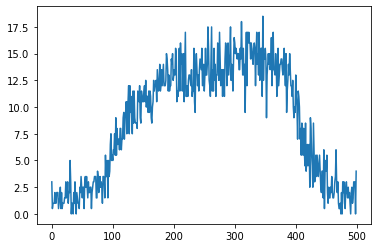

In [22]:
plt.plot(np.arange(len(score)), score)

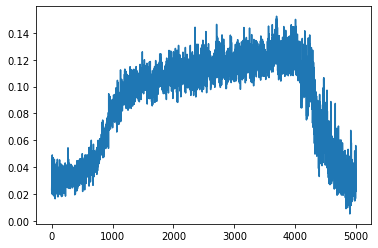

In [19]:
n_epochs = np.arange(len(losses['critic_losses']))
plt.plot(n_epochs, losses['critic_losses'])

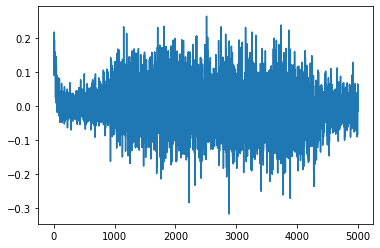

In [20]:
plt.plot(n_epochs, losses['actor_losses'])

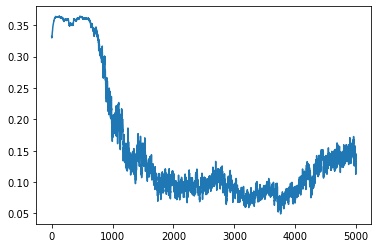

In [21]:
plt.plot(n_epochs, -np.array(losses['entropies']))

# Line by line

In [ ]:
RESOLUTION = 16
MAX_STEPS = 256
game_params = dict(feature_screen=RESOLUTION, feature_minimap=RESOLUTION, action_space="FEATURES") 

In [ ]:
env = init_game(game_params, max_steps=MAX_STEPS)

In [ ]:
HPs = dict(action_space=3, n_layers=2, in_channels=3, n_channels=12, linear_size=RESOLUTION,
           gamma=0.99, n_steps = 20, pixel_n_residuals=2, feature_n_residuals=2)

if torch.cuda.is_available():
    HPs['device'] = 'cuda'
else:
    HPs['device'] = 'cpu'
    
print("Using device "+HPs['device'])

lr = 1e-4
agent = MoveToBeaconSpatialA2C(env=env, **HPs)

In [ ]:
unroll_length = 240

train_dict = dict(n_train_processes = 11,
                  max_train_steps = unroll_length*100,
                  unroll_length = unroll_length,
                  max_episode_steps = MAX_STEPS,
                  test_interval = unroll_length*10 #100
                  )

In [7]:
envs = ParallelEnv(n_train_processes, game_params, max_steps)

reset done
info sent
reset done
info sent


In [8]:
optimizer = torch.optim.Adam(agent.AC.parameters(), lr=lr)

In [9]:
s, a_mask = envs.reset()
print("s.shape: ", s.shape)
print("a_mask.shape: ", a_mask.shape)
print("a_mask: ", a_mask)

s.shape:  (2, 3, 16, 16)
a_mask.shape:  (2, 3)
a_mask:  [[False False  True]
 [False False  True]]


## AC step

To make a batched step we already have the state in the correct shape, but we need to:
1. change get_action_mask of the AC so to work with a list of arrays - DONE
2. sample all parameters every time, so that we don't need to loop between the parameter networks to get the right ones and we can vectorize it
3. select only the parameters that we neeed

Each action has 0, 1 or 2 parameters associated. We should sample a batch of arguments for each parameter of each argument and then access only the correct ones. We need a bit of structure to do that.

(batch_dim, [[params0],[params1],[params2]])
and same thing for the log_prob

Unfortunately we get something like ([[],[(batch_dim, args)],[(batch_dim, arg1),(batch_dim, arg2)]])

In [10]:
action, log_prob, probs = agent.step(s, a_mask)


action mask:  tensor([[False, False,  True],
        [False, False,  True]], device='cuda:0')
logits shape:  torch.Size([2, 3])
logits:  tensor([[-1.6008, -0.7392, -1.1371],
        [-1.7987, -0.6966, -1.0900]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward>)
mask shape:  torch.Size([2, 3])
mask:  tensor([[False, False,  True],
        [False, False,  True]], device='cuda:0')
logits (after mask):  tensor([[-1.6008, -0.7392,    -inf],
        [-1.7987, -0.6966,    -inf]], device='cuda:0',
       grad_fn=<IndexPutBackward>)
log_probs:  tensor([[-1.2141, -0.3524,    -inf],
        [-1.3889, -0.2868,    -inf]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward>)
spatial_features.shape:  torch.Size([2, 12, 16, 16])
spatial_features (cuda):  True
nonspatial_features.shape:  torch.Size([2, 12])
nonspatial_features (cuda):  True
probs:  tensor([[0.2970, 0.7030, 0.0000],
        [0.2493, 0.7507, 0.0000]], device='cuda:0', grad_fn=<ExpBackward>)
log_prob:  tensor([-0.3524, -0.2868], dev

In [11]:
s_prime, r, done, bootstrap, s_trg, a_mask = envs.step(action)


In [13]:
print("s_prime.shape; ", s_prime.shape)
print("r.shape: ", r.shape)
print("done.shape: ", done.shape)
print("bootstrap.shape: ", bootstrap.shape)
print("s_trg.shape: ", s_trg.shape)
print("a_mask.shape: ", a_mask.shape)

s_prime.shape;  (2, 3, 16, 16)
r.shape:  (2,)
done.shape:  (2,)
bootstrap.shape:  (2,)
s_trg.shape:  (2, 3, 16, 16)
a_mask.shape:  (2, 3)


In [16]:
#print("s_prime: ", s_prime)
print("r: ", r)
print("done: ", done)
print("bootstrap: ", bootstrap)
#print("s_trg: ", s_trg)
print("a_mask: ", a_mask)

r:  [0 0]
done:  [False False]
bootstrap:  [False False]
a_mask:  [[False False False]
 [False False False]]


In [15]:
action, log_prob, probs = agent.step(s_prime, a_mask)


action mask:  tensor([[False, False, False],
        [False, False, False]], device='cuda:0')
logits shape:  torch.Size([2, 3])
logits:  tensor([[-1.6421, -0.7365, -1.1158],
        [-1.7094, -0.7659, -1.0381]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward>)
mask shape:  torch.Size([2, 3])
mask:  tensor([[False, False, False],
        [False, False, False]], device='cuda:0')
logits (after mask):  tensor([[-1.6421, -0.7365, -1.1158],
        [-1.7094, -0.7659, -1.0381]], device='cuda:0',
       grad_fn=<IndexPutBackward>)
log_probs:  tensor([[-1.6421, -0.7365, -1.1158],
        [-1.7094, -0.7659, -1.0381]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward>)
spatial_features.shape:  torch.Size([2, 12, 16, 16])
spatial_features (cuda):  True
nonspatial_features.shape:  torch.Size([2, 12])
nonspatial_features (cuda):  True
probs:  tensor([[0.1936, 0.4788, 0.3277],
        [0.1810, 0.4649, 0.3541]], device='cuda:0', grad_fn=<ExpBackward>)
log_prob:  tensor([-0.7365, -1.0381], dev

In [17]:
s_prime, r, done, bootstrap, s_trg, a_mask = envs.step(action)

In [19]:
envs.close()

In [15]:
import torch
import torch.nn.functional as F

In [26]:
logits = torch.rand((2,3), requires_grad=True)
mask = torch.tensor([[False, False, True], [False, False, True]])
x = F.log_softmax(logits.masked_fill((mask).bool(), float('-inf')), dim=-1) 

In [28]:
x.sum().backward()